<a href="https://colab.research.google.com/github/Daffa-afaf/Klasifikasi-wine-kuantum/blob/main/Klasifikasi-wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y qiskit qiskit-machine-learning qiskit-algorithms

!pip install qiskit==0.45.0 qiskit-machine-learning==0.7.2 qiskit-algorithms==0.2.1 numpy==1.24.4

Found existing installation: qiskit 0.45.0
Uninstalling qiskit-0.45.0:
  Successfully uninstalled qiskit-0.45.0
Found existing installation: qiskit-machine-learning 0.7.2
Uninstalling qiskit-machine-learning-0.7.2:
  Successfully uninstalled qiskit-machine-learning-0.7.2
Found existing installation: qiskit-algorithms 0.2.1
Uninstalling qiskit-algorithms-0.2.1:
  Successfully uninstalled qiskit-algorithms-0.2.1
  Using cached qiskit-0.45.0-py3-none-any.whl.metadata (12 kB)
  Using cached qiskit_machine_learning-0.7.2-py3-none-any.whl.metadata (12 kB)
  Using cached qiskit_algorithms-0.2.1-py3-none-any.whl.metadata (4.1 kB)
Using cached qiskit-0.45.0-py3-none-any.whl (9.6 kB)
Using cached qiskit_machine_learning-0.7.2-py3-none-any.whl (97 kB)
Using cached qiskit_algorithms-0.2.1-py3-none-any.whl (306 kB)


In [ ]:
# Install the required library for drawing circuits with matplotlib
!pip install pylatexenc

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
import seaborn as sns

In [ ]:
from sklearn.datasets import load_wine
wine_data = load_wine()
x = wine_data.data  # Fitur (178 record/sampel anggur, 13 fitur)
y = wine_data.target  # Label (3 kelas)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Sampling 150 record jika > 150
if len(x) > 150:
    indices = np.random.choice(len(x), 150, replace=False)
    x = x[indices]
    y = y[indices]

# Normalisasi data
x = MinMaxScaler().fit_transform(x)

# Reduksi fitur menjadi 4 menggunakan PCA
pca = PCA(n_components=4)
x = pca.fit_transform(x)

# Split data menjadi training dan testing
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 123
train_x, test_x, train_y, test_y = train_test_split(
    x, y, train_size=0.8, random_state=algorithm_globals.random_seed
)

1. Dataset Wine dimuat dengan 13 fitur dan 178 record.
2. Karena record > 150, kode mengambil 150 record secara acak.
3. Data dinormalisasi menggunakan MinMaxScaler.
4. PCA diterapkan untuk mereduksi 13 fitur menjadi 4 fitur.

### Parameterized Circuit: Feature Map Buatan Sendiri

/usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


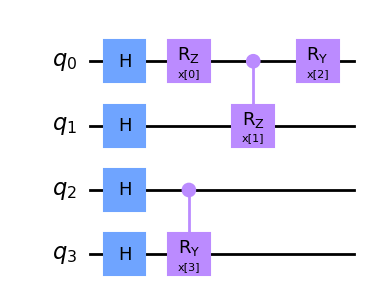

In [ ]:
jum_fitur = x.shape[1]
theta_list = ParameterVector('x', length=jum_fitur)

feature_map_1 = QuantumCircuit(jum_fitur)
feature_map_1.h([0,1,2,3])
feature_map_1.rz(theta_list[0], 0) #Menerapkan gerbang rotasi Z (RZ) dengan parameter theta_list[0] pada qubit 0.
feature_map_1.crz(theta_list[1], 0, 1) #Menerapkan gerbang controlled-RZ dengan parameter theta_list[1], qubit 0 sebagai kontrol, dan qubit 1 sebagai target.
feature_map_1.ry(theta_list[2], 0)
feature_map_1.cry(theta_list[3], 2, 3)
feature_map_1.draw('mpl')

### Parameterized Circuit: Feature Map menggunakan Library di Qiskit

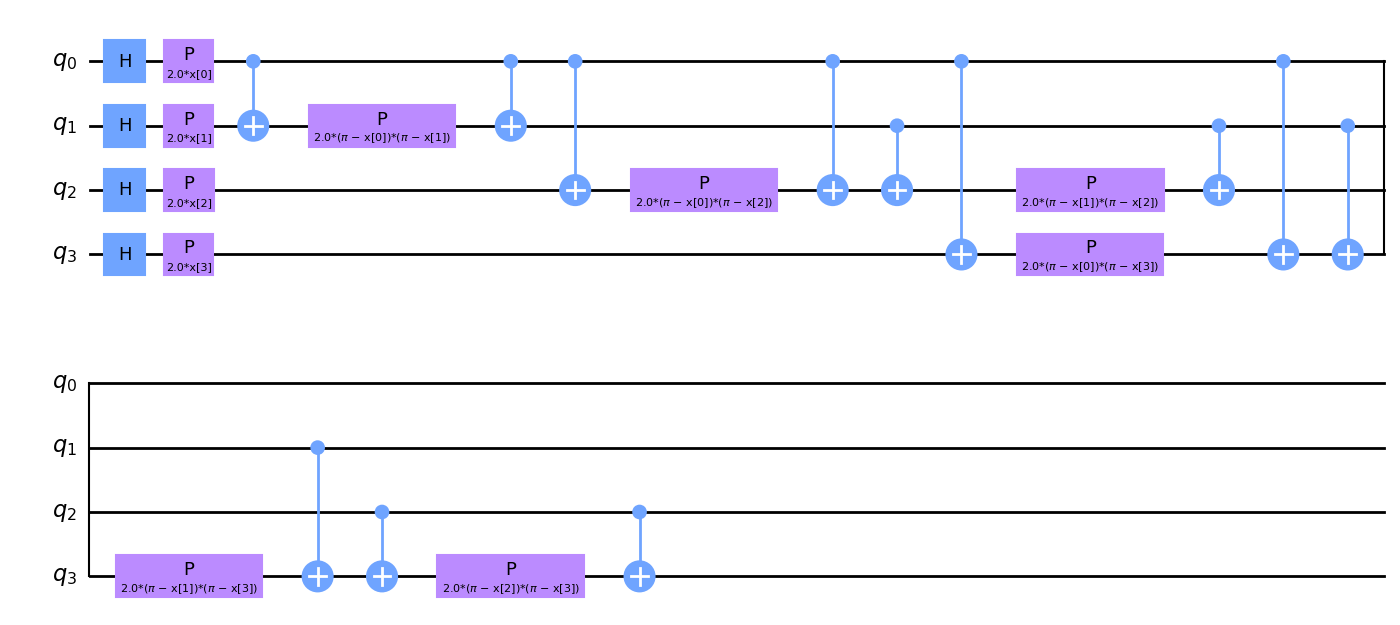

In [ ]:
from qiskit.circuit.library import ZZFeatureMap

jum_fitur = x.shape[1]

feature_map_2 = ZZFeatureMap(feature_dimension=jum_fitur, reps=1)
feature_map_2.decompose().draw(output="mpl", style="clifford", fold=20)

### Parameterized Circuit: Ansatz Buatan Sendiri

/usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


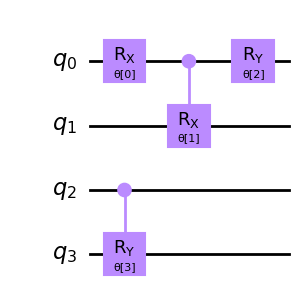

In [ ]:
theta_list = ParameterVector('θ', length=jum_fitur)

ansatz_1 = QuantumCircuit(jum_fitur)
ansatz_1.rx(theta_list[0], 0)
ansatz_1.crx(theta_list[1], 0, 1)
ansatz_1.ry(theta_list[2], 0)
ansatz_1.cry(theta_list[3], 2, 3)
ansatz_1.draw('mpl')

### Parameterized Circuit: Anzats menggunakan Library di Qiskit

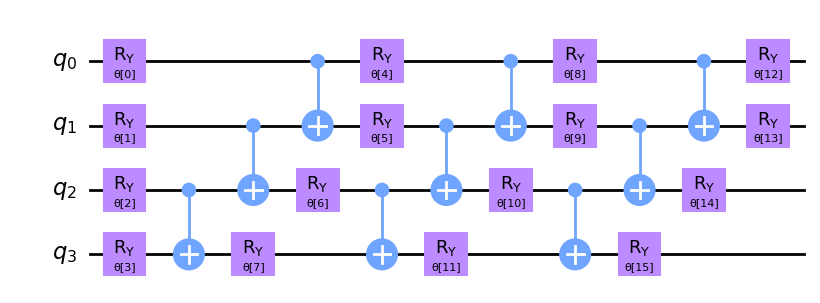

In [ ]:
from qiskit.circuit.library import RealAmplitudes

ansatz_2 = RealAmplitudes(num_qubits=jum_fitur, reps=3)
ansatz_2.decompose().draw(output="mpl", style="clifford", fold=20)

In [ ]:
from qiskit.primitives import Sampler

sampler = Sampler()

### Fungsi untuk menggambar proses pelatihan

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Nilai fungsi objektif terhadap iterasi")
    plt.xlabel("Iterasi")
    plt.ylabel("Nilai fungsi objektif")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
optimizer = COBYLA(maxiter=200)

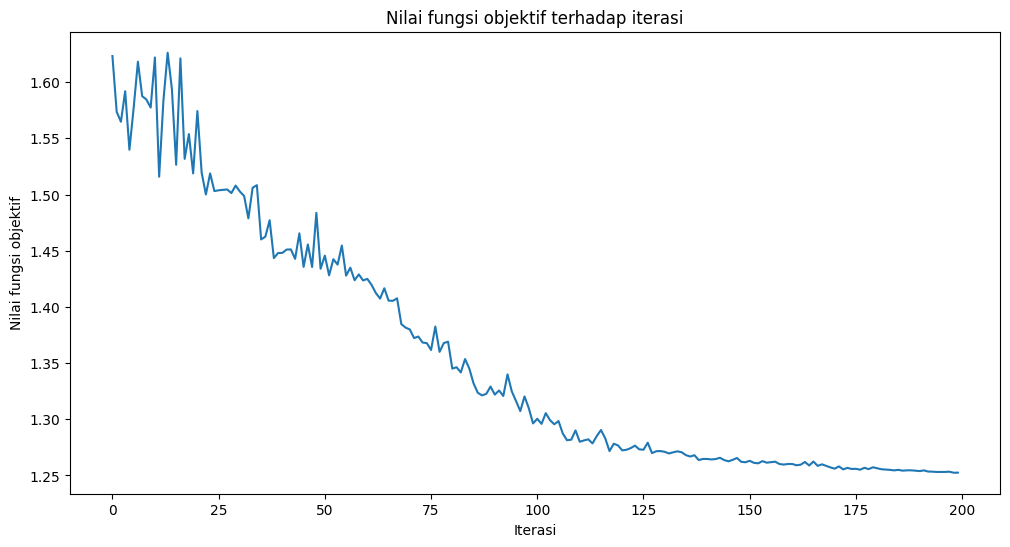

Waktu Training : 204 detik


In [ ]:
# inisialisasi dan melatih model Variational Quantum Classifier (VQC) menggunakan ZZFeatureMap untuk encoding data dan RealAmplitudes sebagai ansatz.
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map_2,  # sebagai alternatif: feature_map_2
    ansatz=ansatz_2,            # sebagai alternatif: ansatz_2
    optimizer=optimizer,
    callback=callback_graph,
)

# hapus histori nilai oyektif
objective_func_vals = []

start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Waktu Training : {round(elapsed)} detik")

Mari kita lihat bagaimana model kuantum bekerja pada kumpulan data kehidupan nyata.

In [ ]:
score_pelatihan_1 = vqc.score(train_x, train_y)
score_pengujian_1 = vqc.score(test_x, test_y)

print(f"VQC kuantum pada dataset pelatihan: {score_pelatihan_1:.2f}")
print(f"VQC kuantum pada dataset uji      : {score_pengujian_1:.2f}")

VQC kuantum pada dataset pelatihan: 0.67
VQC kuantum pada dataset uji      : 0.47


## Mengurangi Jumlah Fitur menggunakan PCA

<Axes: >

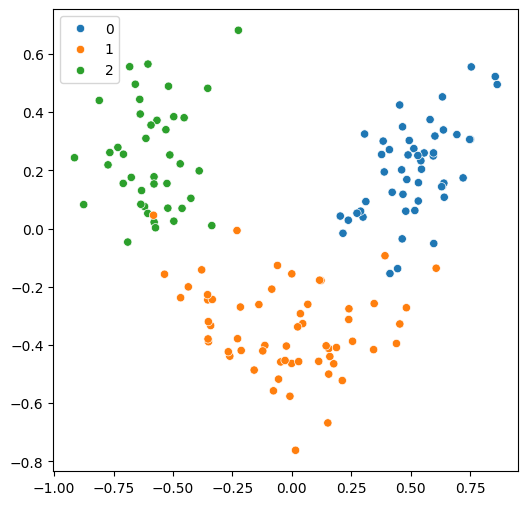

In [ ]:
jum_fitur = 2
x_PCA = PCA(n_components=jum_fitur).fit_transform(x)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=x_PCA[:, 0], y=x_PCA[:, 1], hue=y, palette="tab10")

In [ ]:
# Data yang sudah direduksi ke 2D dilakukakan pemisahan data
train_x, test_x, train_y, test_y = train_test_split(
    x_PCA, y, train_size=0.8, random_state=algorithm_globals.random_seed
)

### Parameterized Circuit: Feature Map Buatan Sendiri

/usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


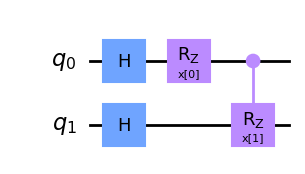

In [ ]:
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit

theta_list = ParameterVector('x', length=jum_fitur)

feature_map_1 = QuantumCircuit(jum_fitur)
feature_map_1.h([0,1])
feature_map_1.rz(theta_list[0], 0)
feature_map_1.crz(theta_list[1], 0, 1)
feature_map_1.draw('mpl')

### Parameterized Circuit: Ansatz Buatan Sendiri

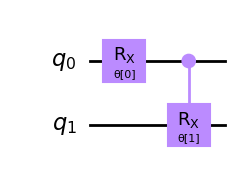

In [ ]:
theta_list = ParameterVector('θ', length=jum_fitur)

ansatz_1 = QuantumCircuit(jum_fitur)
ansatz_1.rx(theta_list[0], 0)
ansatz_1.crx(theta_list[1], 0, 1)
ansatz_1.draw('mpl')

In [ ]:
feature_map_2 = ZZFeatureMap(feature_dimension=jum_fitur, reps=1)
ansatz_2 = RealAmplitudes(num_qubits=jum_fitur, reps=3)

In [ ]:
optimizer = COBYLA(maxiter=200)

Sekarang kita membangun pengklasifikasi kuantum dari parameter baru dan melatihnya.

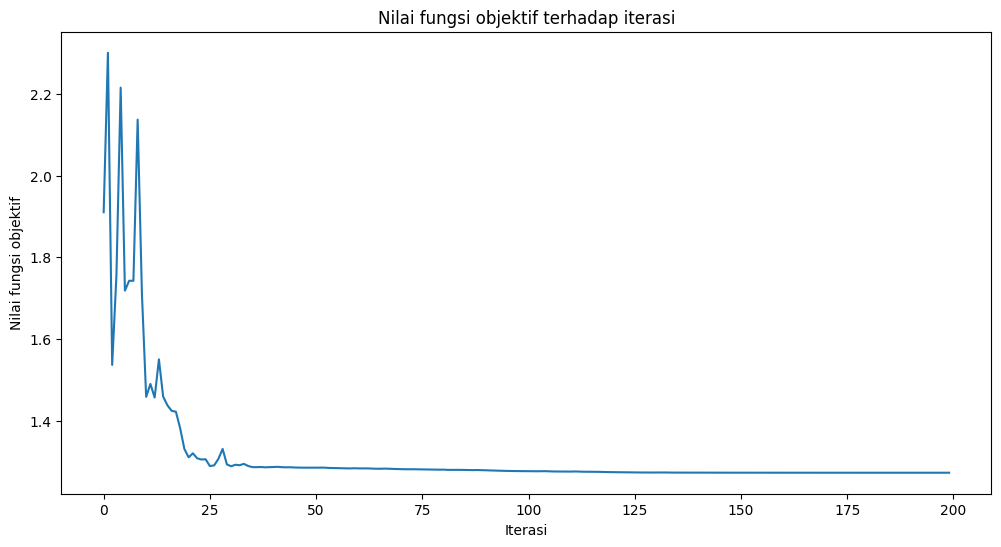

Waktu Training: 106 detik


In [ ]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map_2,
    ansatz=ansatz_2,
    optimizer=optimizer,
    callback=callback_graph,
)

# hapus histori nilai obyektif
objective_func_vals = []

# membuat plot fungsi objektif terlihat lebih bagus.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Waktu Training: {round(elapsed)} detik")

In [ ]:
score_pelatihan_2 = vqc.score(train_x, train_y)
score_pengujian_2 = vqc.score(test_x, test_y)

print(f"VQC kuantum pada dataset pelatihan menggunakan RealAmplitudes: {score_pelatihan_2:.2f}")
print(f"VQC kuantum pada dataset uji menggunakan RealAmplitudes      : {score_pengujian_2:.2f}")

VQC kuantum pada dataset pelatihan menggunakan RealAmplitudes: 0.46
VQC kuantum pada dataset uji menggunakan RealAmplitudes      : 0.43


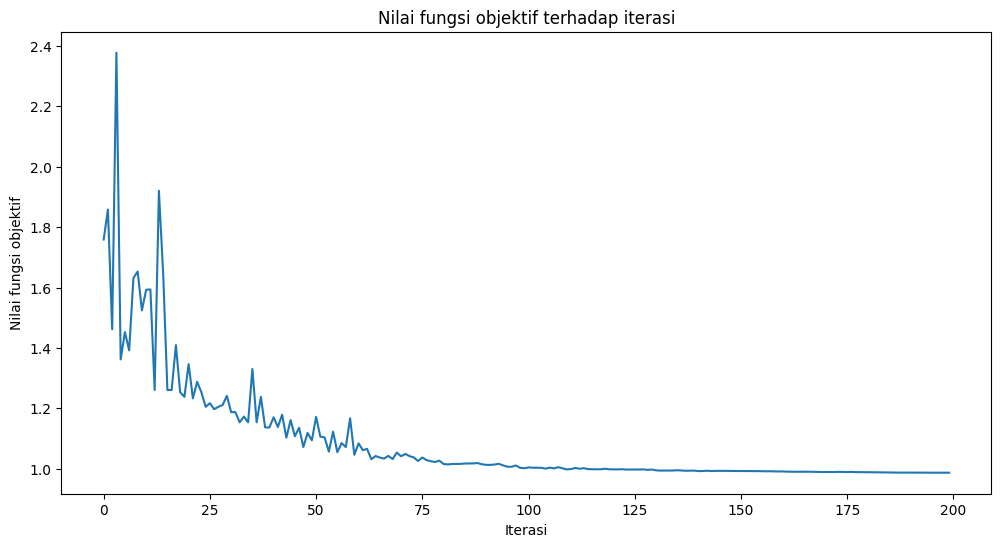

Waktu Training: 132 detik


In [ ]:
from qiskit.circuit.library import EfficientSU2

ansatz_1 = EfficientSU2(num_qubits=jum_fitur, reps=3)
optimizer = COBYLA(maxiter=200)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map_2,
    ansatz=ansatz_1,               #  pakai anzats baru
    optimizer=optimizer,
    callback=callback_graph,
)

objective_func_vals = []

start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Waktu Training: {round(elapsed)} detik")

In [ ]:
score_pelatihan_3 = vqc.score(train_x, train_y)
score_pengujian_3 = vqc.score(test_x, test_y)

print(f"VQC kuantum pada dataset pelatihan menggunakan EfficientSU2: {score_pelatihan_3:.2f}")
print(f"VQC kuantum pada dataset uji menggunakan EfficientSU2      : {score_pengujian_3:.2f}")

VQC kuantum pada dataset pelatihan menggunakan EfficientSU2: 0.76
VQC kuantum pada dataset uji menggunakan EfficientSU2      : 0.80


In [ ]:
print(f"Model                     | Score Pelatihan | Score Pengujian")
print(f"VQC, 4 features, Anzats_2 | {score_pelatihan_1:10.2f} | {score_pengujian_1:10.2f}")
print(f"VQC, 2 features, Anzats_2 | {score_pelatihan_2:10.2f} | {score_pengujian_2:10.2f}")
print(f"VQC, 2 features, Anzats_1 | {score_pelatihan_3:10.2f} | {score_pengujian_3:10.2f}")

Model                     | Score Pelatihan | Score Pengujian
VQC, 4 features, Anzats_2 |       0.67 |       0.47
VQC, 2 features, Anzats_2 |       0.46 |       0.43
VQC, 2 features, Anzats_1 |       0.76 |       0.80


# **Uji data dengan Model machine learning non quantum**

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# SVM
model_svm = SVC()
model_svm.fit(train_x, train_y)
pred_svm = model_svm.predict(test_x)
acc_train_svm = model_svm.score(train_x, train_y)
acc_test_svm = accuracy_score(test_y, pred_svm)

# Random Forest
model_rf = RandomForestClassifier(random_state=123)
model_rf.fit(train_x, train_y)
pred_rf = model_rf.predict(test_x)
acc_train_rf = model_rf.score(train_x, train_y)
acc_test_rf = accuracy_score(test_y, pred_rf)

# KNN
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(train_x, train_y)
pred_knn = model_knn.predict(test_x)
acc_train_knn = model_knn.score(train_x, train_y)
acc_test_knn = accuracy_score(test_y, pred_knn)

In [ ]:
# Tabel Perbandingan
print("\nTABEL HASIL NON-QUANTUM")
print(f"{'Model':30s} | {'Train':^8} | {'Test':^8}")
print("-" * 55)
print(f"{'SVM':30s} | {acc_train_svm:8.2f} | {acc_test_svm:8.2f}")
print(f"{'Random Forest':30s} | {acc_train_rf:8.2f} | {acc_test_rf:8.2f}")
print(f"{'K-Nearest Neighbors (k=3)':30s} | {acc_train_knn:8.2f} | {acc_test_knn:8.2f}")


TABEL HASIL NON-QUANTUM
Model                          |  Train   |   Test  
-------------------------------------------------------
SVM                            |     0.97 |     1.00
Random Forest                  |     1.00 |     1.00
K-Nearest Neighbors (k=3)      |     0.97 |     1.00


Ketiga model Non Quantum (SVM, RF, KNN) mencapai akurasi ≥ 97% di training dan 100% di testing. Ini wajar karena model klasik lebih matang dan efisien untuk dataset kecil. Sedangkan model quantum/VQC performanya beragam.



Model Non-Quantum lebih stabil dan akurat pada dataset kecil seperti ini. Sementara model Quantum (VQC) masih sangat tergantung pada jumlah fitur, jenis ansatz, dan tuning parameter. Meskipun hasil VQC kadang impresif (akurasi 1.0), tapi kurang konsisten. Potensi VQC baru akan lebih jelas pada data besar dan kompleks, terutama jika teknologi kuantum sudah lebih matang.